### Import necessary packages and the scikit-learn diabetes dataset

In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from tabularmagic import TabularMagic
from tabularmagic.ml import Linear, Tree, TreeEnsemble, SVM, MLP

diabetes_data = load_diabetes()
df = pd.DataFrame(data=diabetes_data.data, columns=diabetes_data.feature_names)
df['target'] = diabetes_data.target
display(df.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### Create a TabularMagic object

In [2]:
tm = TabularMagic(df, test_size=0, verbose=True)
tm.save_data_checkpoint('test')
print(tm)

UPDATE: TabularMagic initialization complete. Shapes of train, test datasets: (442, 11), (442, 11)
UPDATE: Working datasets checkpoint "test" saved.
TabularMagic
------------------------------------------------
Train shape: (442, 11)  |  Test shape: (442, 11)
------------------------------------------------
Categorical variables: None
                                                
Continuous variables: age, sex, bmi, bp, s1, s2,
s3, s4, s5, s6, target


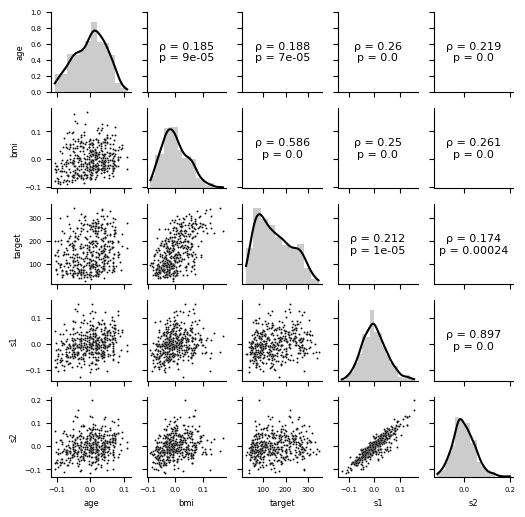

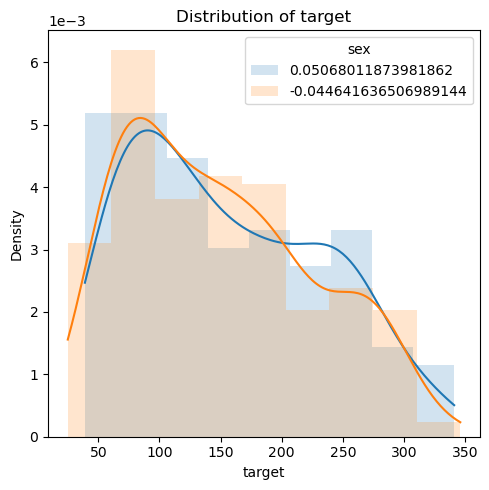

In [3]:

train_eda = tm.eda()
display(train_eda.plot_continuous_pairs(continuous_vars=['age', 'bmi', 'target', 's1', 's2']))
display(train_eda.plot_distribution_stratified('target', 'sex', include_hist=True))
pca_labels = train_eda.df['sex'] == train_eda.df['sex'].unique()[0]

### Basic regression analysis

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     156.4
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           6.48e-69
Time:                        23:23:10   Log-Likelihood:                -2432.8
No. Observations:                 442   AIC:                             4874.
Df Residuals:                     438   BIC:                             4890.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        149.5579      3.308     45.213      0.0

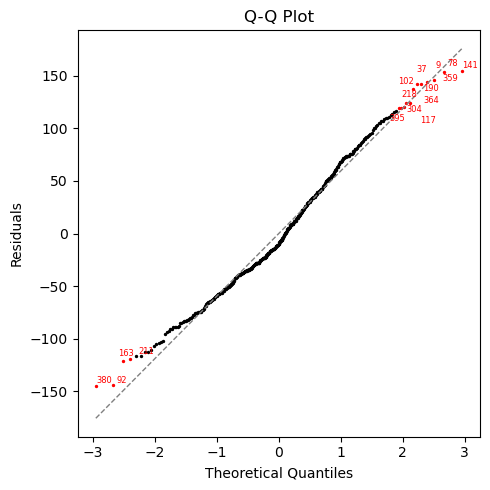

In [4]:
X_vars = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
y_var = 'target'

train_report, test_report = tm.lm_rlike('target ~ bmi + bp + bp * bmi')
train_report.set_outlier_threshold(2)
print(train_report.statsmodels_summary())
train_report.plot_qq(standardized=False, show_outliers=True)

UPDATE: Working datasets reset to original datasets. Shapes of train, test datasets: (442, 11), (442, 11)
UPDATE: Dropped rows [9, 37, 78, 92, 102, 117, 141, 163, 190, 211, 218, 304, 359, 364, 380, 395]. Shapes of train, test datasets: (426, 11), (442, 11)
UPDATE: Working datasets checkpoint "drop_checkpoint" saved.


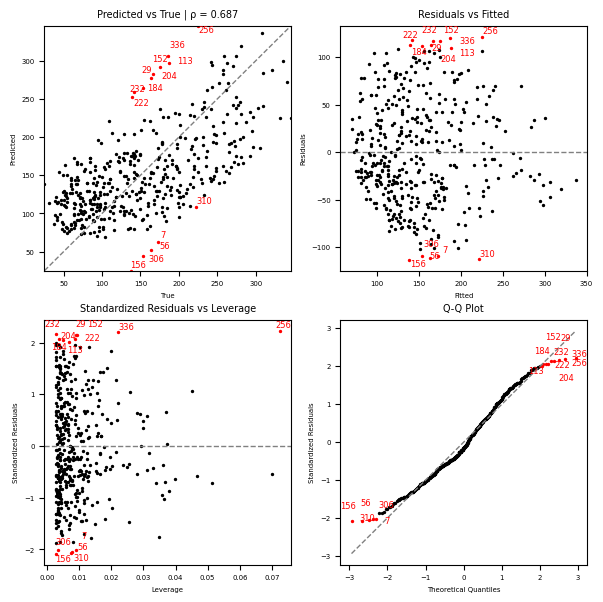

In [5]:
tm.load_data_checkpoint()
tm.drop_train_examples(train_report.get_outlier_indices())
tm.save_data_checkpoint('drop_checkpoint')
train_report, test_report = tm.lm_rlike('target ~ bmi + bp + bp * bmi', inverse_scale_y=True)
display(train_report.plot_diagnostics(show_outliers=True))

### Define a sequence of models

In [6]:
models = [
    # All models have default hyperparameter search methods built in.
    Linear(regularization_type=None, n_jobs=-1),
    Linear(regularization_type='l1', n_jobs=-1),
    Linear(regularization_type='l2', n_jobs=-1),

    # You can manually set the inner cross validation details
    Tree(n_jobs=-1, random_state=42, inner_cv=10, inner_cv_seed=0, 
         verbose=1),

    TreeEnsemble(ensemble_type='random_forest', n_jobs=-1, random_state=42),
    TreeEnsemble(ensemble_type='xgboost', n_jobs=-1),

    # You can manually set the nickname of a model
    SVM(kernel='rbf', nickname='SVM(rbf)', n_jobs=-1),
    
    # You can manually specify the hypeparameter search method
    # in an sklearn-like manner. 
    MLP(
        hyperparam_search_method='grid',
        hyperparam_grid_specification={
            'hidden_layer_sizes': [(50), (100), (50, 50)],
            'activation': ['relu'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [200]
        }
    )
]

### Conduct a benchmarking exercise with the specified models

In [7]:
train_report, test_report = tm.ml_regression_benchmarking(
    X_vars=X_vars,
    y_var=y_var,
    models=models,
    outer_cv=None,
)

UPDATE: Task 1 of 8.	Fitting Linear(None).
UPDATE: Task 2 of 8.	Fitting Linear(l1).
UPDATE: Task 3 of 8.	Fitting Linear(l2).
UPDATE: Task 4 of 8.	Fitting Tree.
Fitting 10 folds for each of 27 candidates, totalling 270 fits
UPDATE: Task 5 of 8.	Fitting TreeEnsemble(random_forest).
UPDATE: Task 6 of 8.	Fitting TreeEnsemble(xgboost).
UPDATE: Task 7 of 8.	Fitting SVM(rbf).
UPDATE: Task 8 of 8.	Fitting MLP.


### View the train and test model metrics

In [8]:
display(train_report.fit_statistics)

,Linear(None),Linear(l1),Linear(l2),Tree,TreeEnsemble(random_forest),TreeEnsemble(xgboost),SVM(rbf),MLP
Statistic,,,,,,,,
mse,2512.431877,2528.223718,2521.640693,2774.179185,1412.800003,2691.058277,2254.640084,3355.437594
mad,40.986725,41.266835,41.124544,42.291462,31.231929,44.529868,37.276019,48.886412
pearsonr,0.743216,0.741682,0.742327,0.711151,0.872845,0.798932,0.776318,0.664220
spearmanr,0.722678,0.721021,0.721788,0.702346,0.846906,0.772278,0.756857,0.658394
r2,0.552370,0.549556,0.550729,0.505735,0.748287,0.520545,0.598300,0.402175
adjr2,0.541584,0.538702,0.539903,0.493825,0.742222,0.508992,0.588620,0.387770
n,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000


In [9]:
display(test_report.fit_statistics)

,Linear(None),Linear(l1),Linear(l2),Tree,TreeEnsemble(random_forest),TreeEnsemble(xgboost),SVM(rbf),MLP
Statistic,,,,,,,,
mse,2884.847915,2910.684206,2900.667659,3267.405093,1926.908917,3135.250638,2667.768656,3683.502620
mad,43.488880,43.826403,43.657697,45.249685,34.548118,47.248607,40.048434,50.982064
pearsonr,0.717025,0.714394,0.715405,0.670783,0.828345,0.757799,0.745625,0.645151
spearmanr,0.699802,0.696993,0.698747,0.673377,0.814961,0.743946,0.732398,0.642513
r2,0.513507,0.509150,0.510839,0.448994,0.675051,0.471280,0.550115,0.378824
adjr2,0.502219,0.497761,0.499490,0.436209,0.667512,0.459012,0.539676,0.364411
n,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000


### View the predicted vs true scatter plot of the SVM model on testing data.

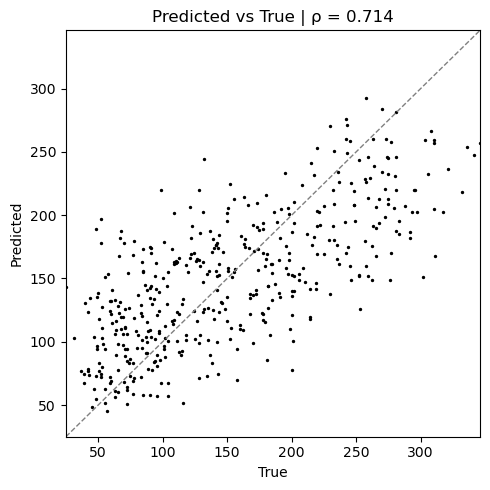

In [10]:
fig = test_report['Linear(l1)'].plot_pred_vs_true()
fig